In [1]:
from collections import defaultdict
from typing import Any, Literal
import numpy as np
from scipy.spatial import KDTree, Voronoi, ConvexHull, voronoi_plot_2d
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from typing import Callable, Tuple
import warnings
import abc
from typing import Any, cast
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc


cast_rv_continuous = lambda x: cast(scipy.stats.rv_continuous, x)


class RadialSpace:
    'Hyperspheres in R^d'

    @classmethod
    def d_volume(cls, d:int|np.ndarray, r:float|np.ndarray=1):
        'Volume enclosed by the hypersphere in d dimensions with radius r'
        return np.pi**(d/2) / scipy.special.gamma(1 + d/2) * r**d
    
    @classmethod
    def d_surface(cls, d:int|np.ndarray, r:float|np.ndarray=1):
        'Surface of the hypersphere in d dimensions with radius r, i.e. derivative of volume(r) wrt r'
        return np.pi**(d/2) / scipy.special.gamma(1 + d/2) * r**(d-1) * d
    
    
    _cache_instances = {} # class attribute to cache instances
    def __new__(cls, d:int):
        key = (cls.__name__, d)
        obj = cls._cache_instances.get(key)
        if obj is not None:
            return obj
        obj = super().__new__(cls)
        obj._init(d)
        cls._cache_instances[key] = obj
        return obj
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d})"

    def _init(self, d:int): # if it was called __init__, it would be called even if cached 
        assert d==round(d) and d>=1, d
        self.d = d
        'Mass of a unit hypersphere in d dimensions with constant unit density'
        self._unit_vol = self.d_volume(1)
        self._unit_surface = self.d_surface(1)
    
    def volume(self, r:float|np.ndarray=1):
        return self.d_volume(self.d, r)
    
    def surface(self, r:float|np.ndarray=1):
        return self.d_surface(self.d, r)
    
    def random_on_surface(self, r:float|np.ndarray=1, size=None):
        'Draw uniformly from the sphere surface'
        r = np.asarray(r).astype(float)
        shape = r.shape if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        X /= r * np.linalg.norm(X, axis=-1, keepdims=True)
        return X
    
    def surface_marginal_pdf(self, r:float|np.ndarray=1, d:int|None=None):
        'Draw uniformly from the sphere surface and take the first coordinate, ignoring the rest'
        r = np.asarray(r).astype(float)
        d = self.d if d is None else d
        rv = cast_rv_continuous(scipy.stats.beta((d-1)/2, (d-1)/2))
        return rv.pdf((r+1)/2) /2
    
    def alt_random_surface_marginal(self, r:float|np.ndarray=1, size=None, d=None):
        'Alternative to self.random(r, size)[:,0]'
        r = np.asarray(r).astype(float)
        d = self.d if d is None else d
        if d == 1: # (special case: Rademacher distribution)
            return (2*np.random.randint(0, 2, size=size) - 1.0)*r
        rv = cast_rv_continuous(scipy.stats.beta((d-1)/2, (d-1)/2))
        return (rv.rvs(size=size) *2 -1)*r


class IstotropicDistribution(abc.ABC):
    '''
    The total mass is 1 = integral of norm_pdf(r) dr.
    '''
    _r_plot:float # large radius for plotting purposes


    def __init__(self, d:int, r:float=1.0):
        '''
        d: int (dimensionality)
        r: float (radial scale, default 1.0)
        '''
        assert d==round(d) and d>=1, d
        self.space = RadialSpace(d)
        self.d = d
        self.r = r
        self._r_plot = self.r*self.d**0.5*2
        self._post_init()
        self._irr0 = self.pointwise_irradiance(0)
        self.fuzzy_radius = (1/self.space.volume(1)/self._irr0)**(1/d)
    
    @classmethod
    def from_fuzzy_radius(cls, d:int, fuzzy_radius:float):
        'Create a distribution with a given fuzzy_radius'
        r = fuzzy_radius / cls(d, 1).fuzzy_radius
        # # Reminder: Alternative using scipy solver:
        # f = lambda r: cls(d, r).fuzzy_radius - fuzzy_radius
        # r = scipy.optimize.root_scalar(f, bracket=[1e-10, 1e10]).root
        obj = cls(d, r)
        assert np.isclose(obj.fuzzy_radius, fuzzy_radius), (obj.fuzzy_radius, fuzzy_radius)
        return obj

    def _post_init(self):
        pass
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d}, r={self.r})"
    
    @abc.abstractmethod
    def norm_pdf(self, r:float|np.ndarray):
        'Density of |X| for X~self. (r>=0)'
        raise NotImplementedError
    
    def norm_cdf(self, r:float|np.ndarray):
        'probability mass that is enclosed in the hypersphere of radius r. (r>=0)'
        raise NotImplementedError
    
    def random(self, size=None):
        'Draw a sample from the distribution'
        X = self.space.random_on_surface(1, size=size)
        X *= self.random_norm(size)[...,None]
        return X
    
    @abc.abstractmethod
    def random_norm(self, size=None):
        raise NotImplementedError
    
    def pointwise_irradiance(self, r:float|np.ndarray):
        '''
        Equals norm_pdf(r) / space.surface(r)
        This is the "euclidean density" in the following sense:
        Fix any point x at radius r, let B(l) be the hypercube of side l centered at x.
        The pointwise_irradiance is the limit as l goes to 0 of the integral of the distribution
        over B(l) divided by the norm_cdf of l.
        '''
        r = np.where(r==0, 1e-10, r) # Correction for singularity of some rvs
        return self.norm_pdf(r) / self.space.surface(r)
    
    def fuzzy_membership(self, r:float|np.ndarray):
        # Returns a number in [0,1]
        return self.pointwise_irradiance(r) * self.fuzzy_radius
    
    def _ref_marginal(self, r:float|np.ndarray):
        'Just for plotting purposes'
        raise NotImplementedError
    
    def _ref_irradiance(self, r:float|np.ndarray) -> float|np.ndarray:
        'Just for plotting purposes'
        raise NotImplementedError
    

    def marginal_pdf(self, x:float|np.ndarray) -> float|np.ndarray:
        raise NotImplementedError
    
    def _compute_marginal_pdf(self, x:float) -> float:
        'Explicit computation in case no formula is available'
        warnings.warn(f"May have bugs. Not tested yet!")
        f = lambda r: self.pointwise_irradiance((r**2+x**2)**0.5) * self.space.d_surface(self.d-1, r)
        return scipy.integrate.quad(f, 0, np.inf)[0]
    
    def random_marginal(self, r:float|np.ndarray=1, size=None):
        'Alternative to self.random(r, size)[:,0]'
        r = np.asarray(r).astype(float)
        return self.space.alt_random_surface_marginal(size=size) * self.random_norm(size=size)


class ScipyIsotropicDistribution(IstotropicDistribution):
    _rv:scipy.stats.rv_continuous

    def random_norm(self, size=None):
        return self._rv.rvs(size) * self.r

    def norm_pdf(self, r:float|np.ndarray):
        'Density for the prob. that a point chosen uniformly from the hypersphere (norm_cdf) has radius r. (r>=0)'
        return self._rv.pdf(r/self.r) / self.r
    
    def norm_cdf(self, r:float|np.ndarray):
        return self._rv.cdf(r / self.r)

    def norm_rms(self):
        return (self.r**2 * self._rv.moment(2)) ** 0.5
    
    def norm_mean(self):
        return self._rv.moment(1) * self.r


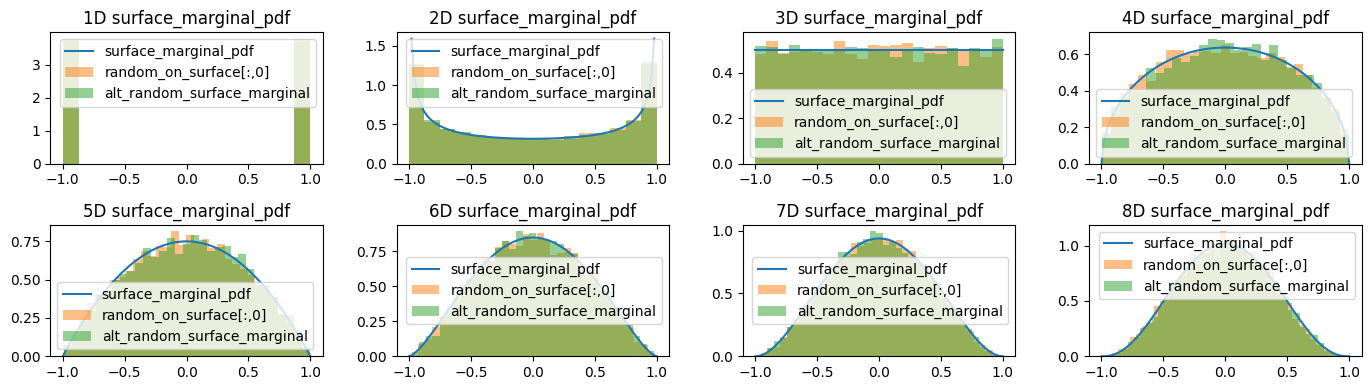

In [2]:


def test_surface_marginal():
    fig, axes = plt.subplots(2, 4, figsize=(14, 4))
    axes = axes.ravel()
    for i_ax in range(len(axes)):
        ax = axes[i_ax]
        d = i_ax + 1
        x = np.linspace(-1, 1, 100)
        y = RadialSpace(d).surface_marginal_pdf(x)
        ax.plot(x, y, label=f'surface_marginal_pdf')
        ax.set_title(f'{d}D surface_marginal_pdf')
        X = RadialSpace(d).random_on_surface(size=10000)[:,0]
        ax.hist(X, bins="auto", density=True, alpha=0.5, label="random_on_surface[:,0]")
        X = RadialSpace(d).alt_random_surface_marginal(size=10000)
        ax.hist(X, bins="auto", density=True, alpha=0.5, label="alt_random_surface_marginal")
        ax.legend()
    plt.tight_layout()
    plt.show()

test_surface_marginal()


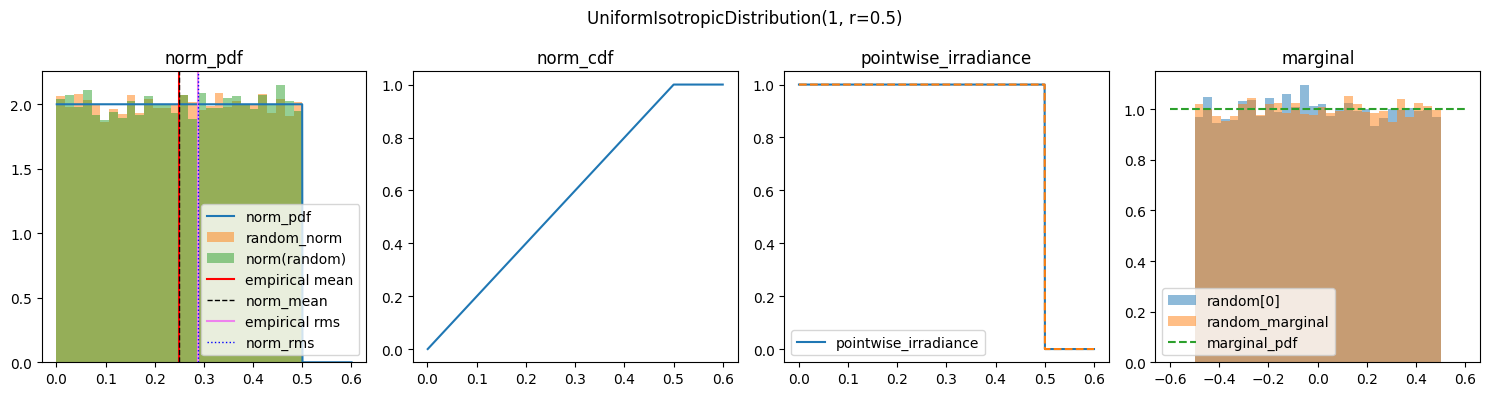

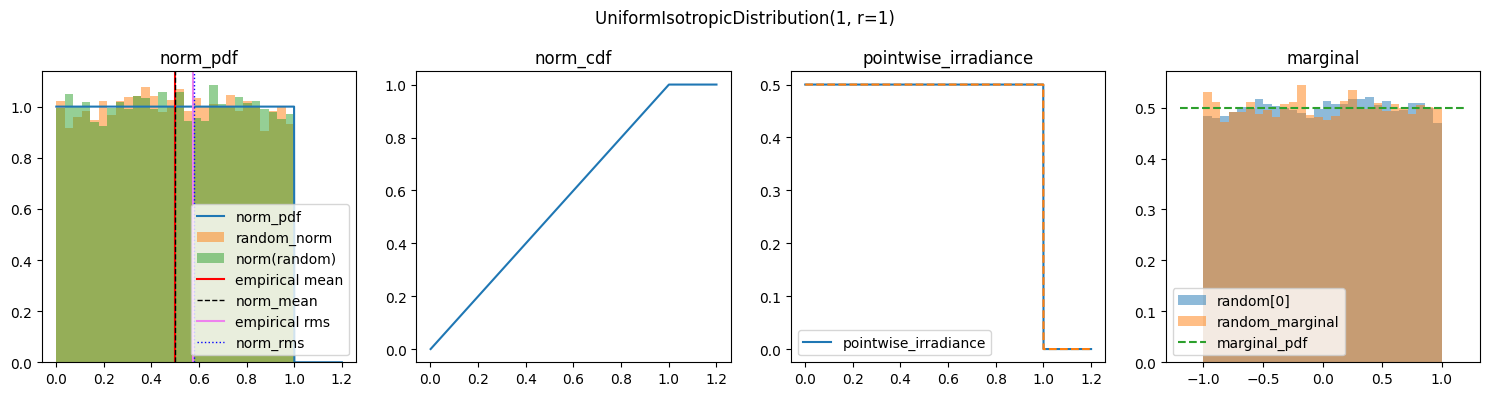

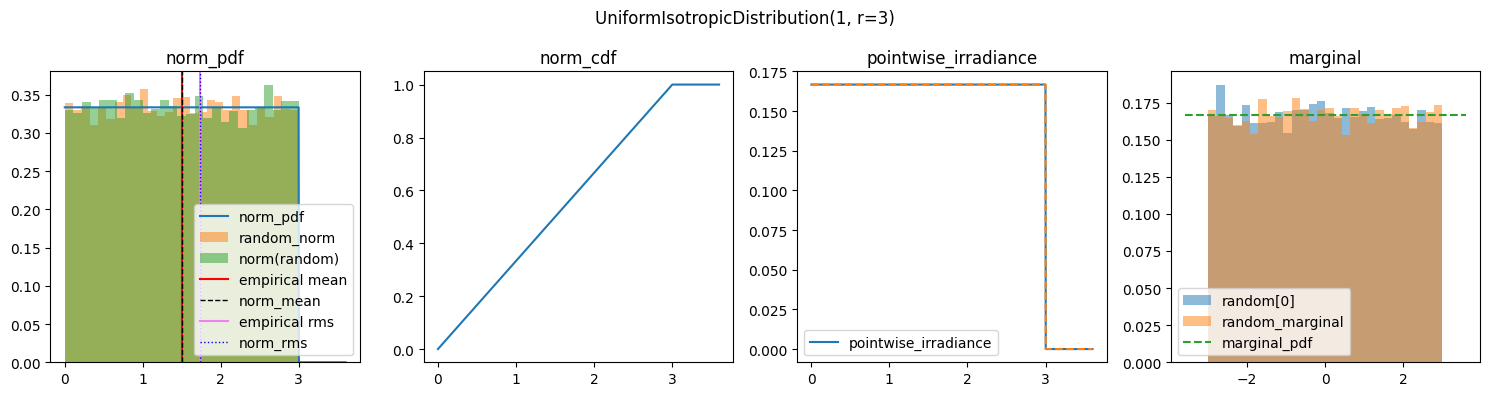

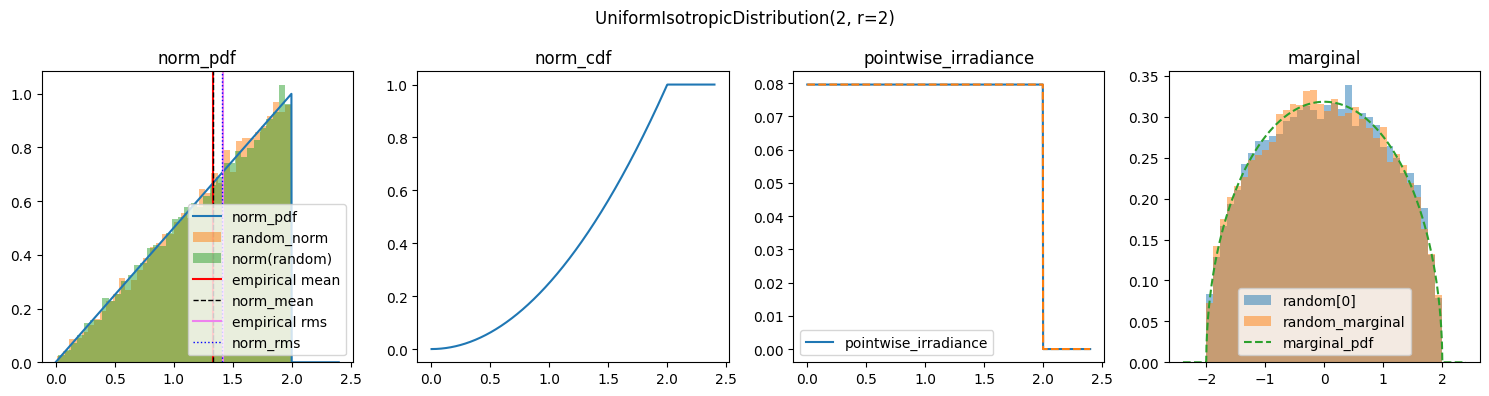

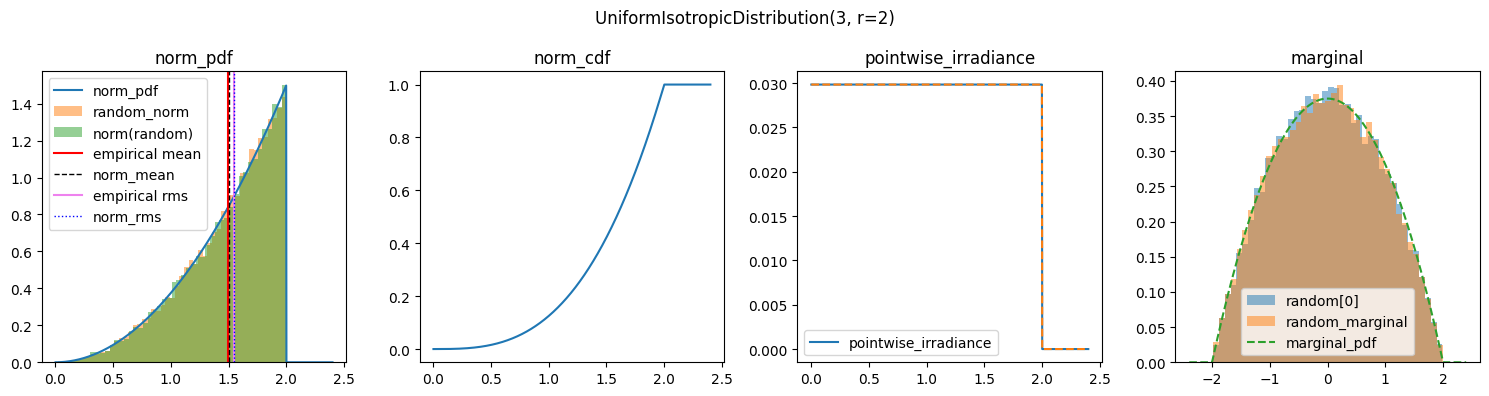

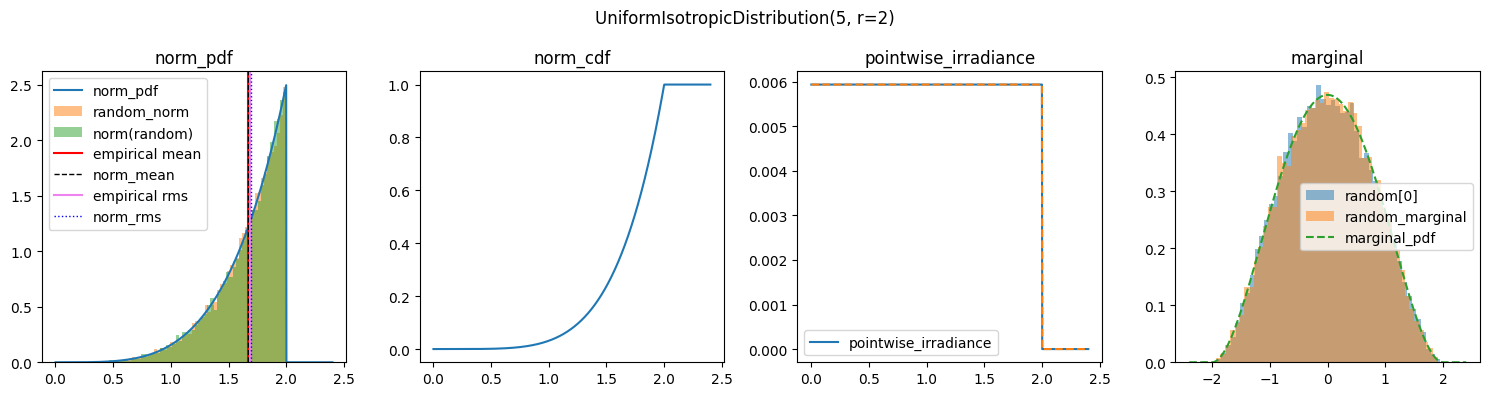

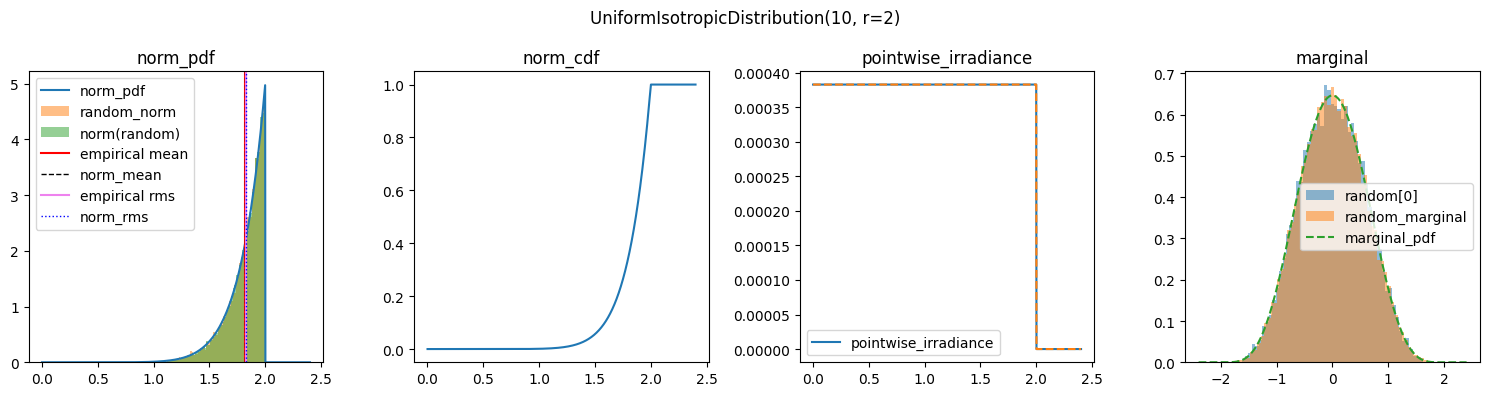

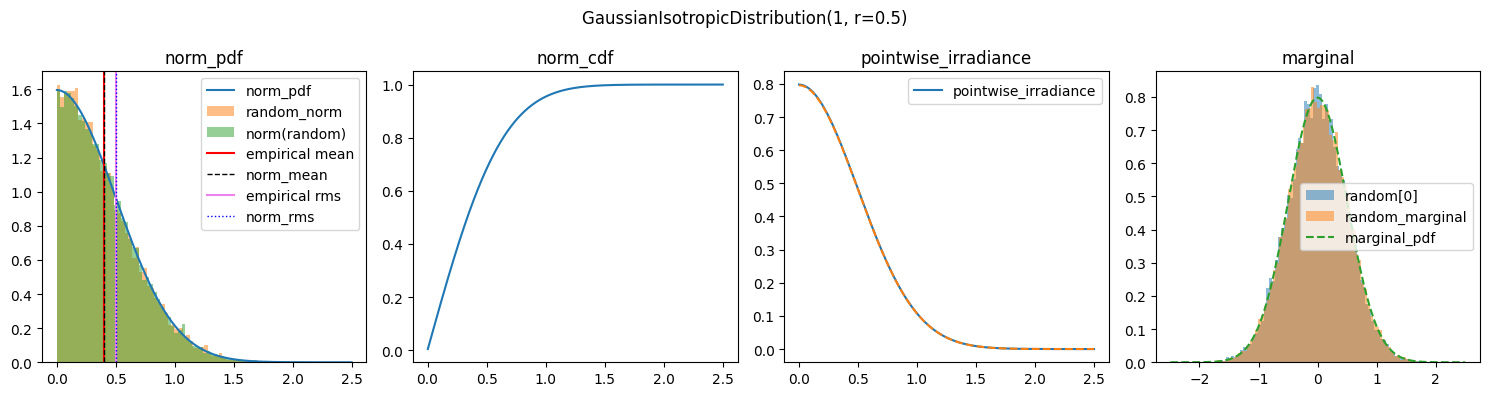

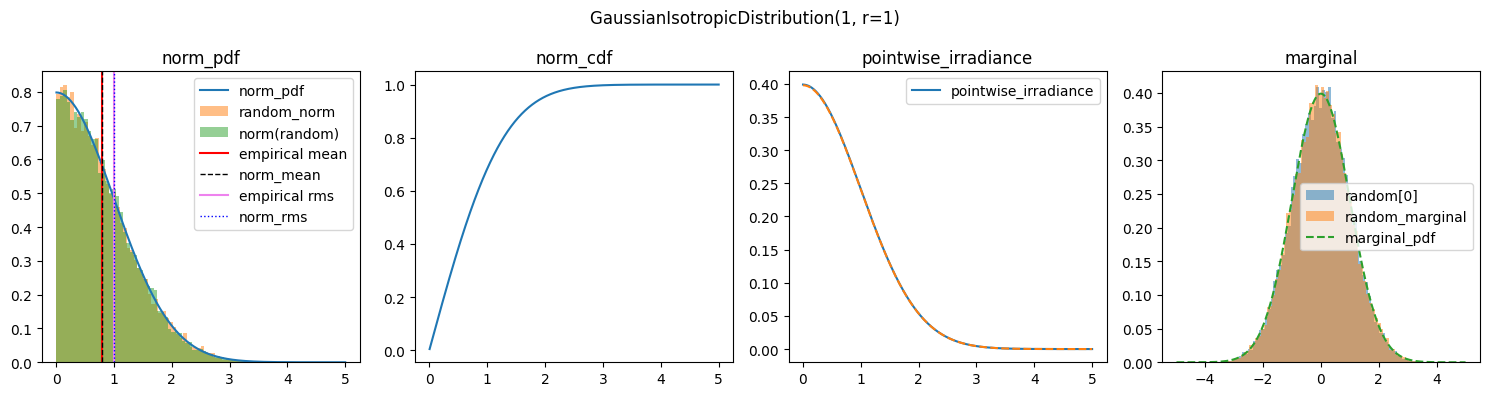

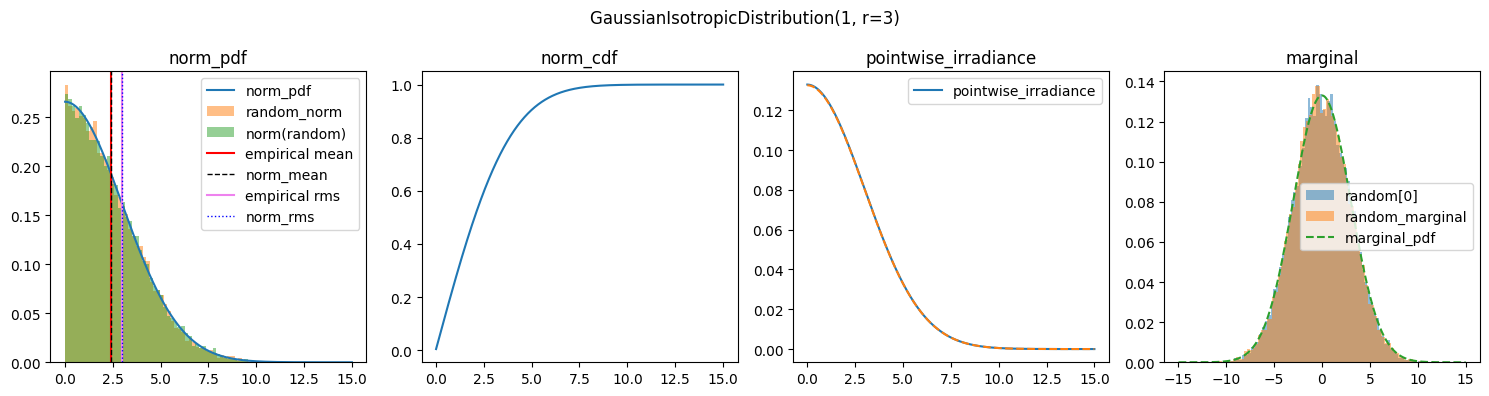

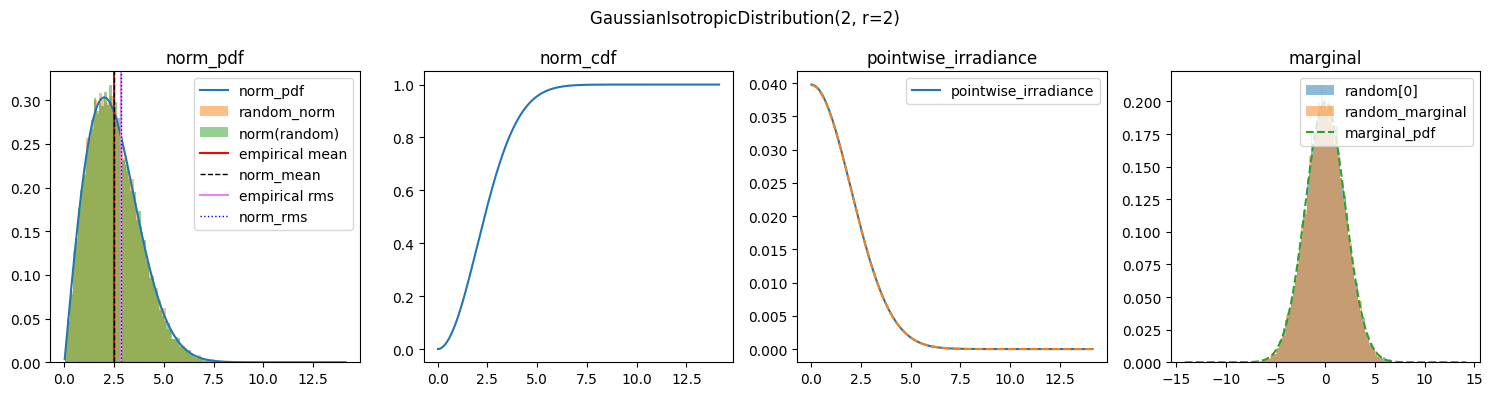

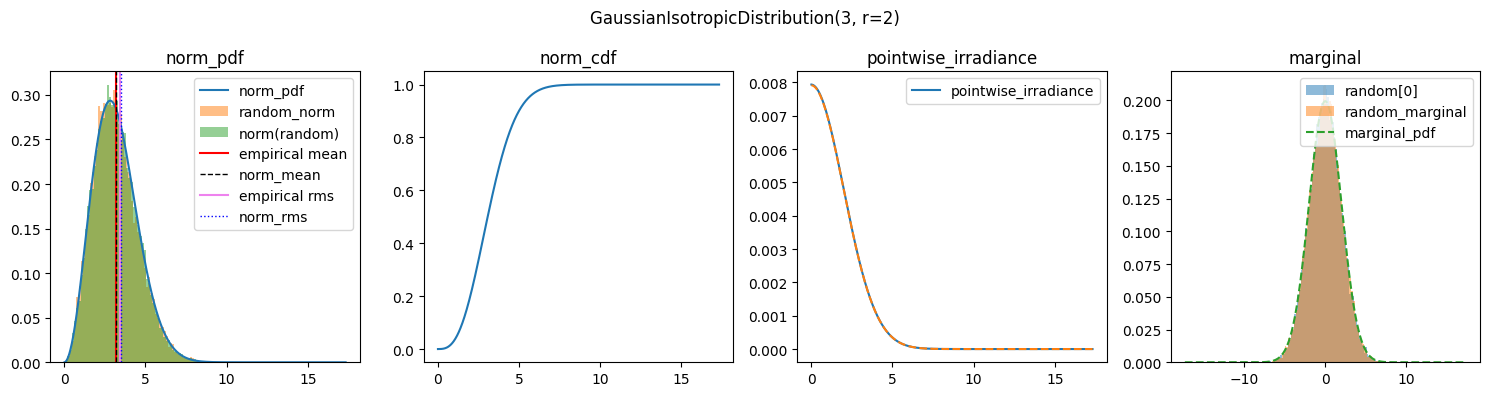

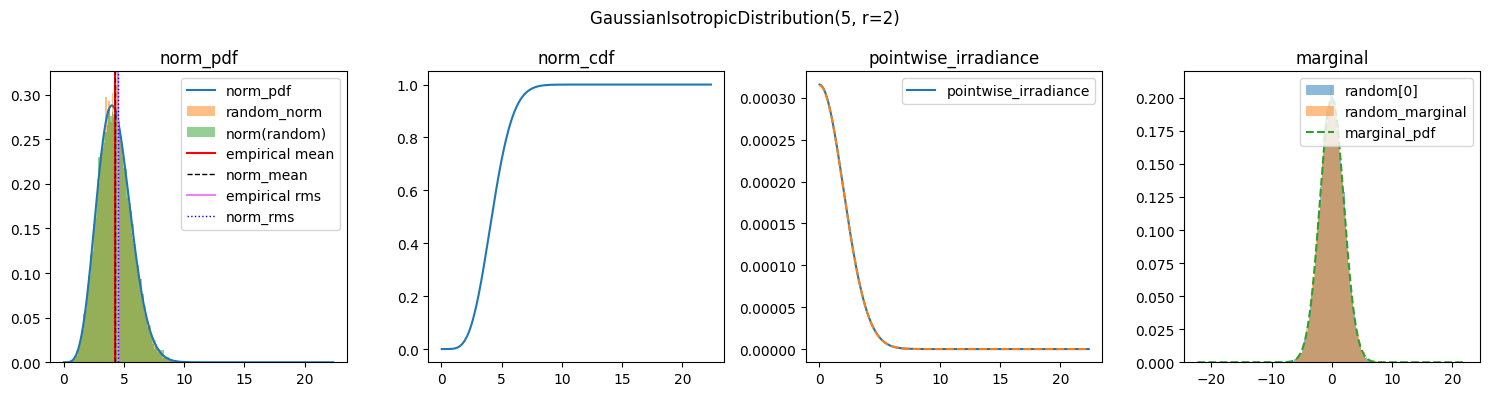

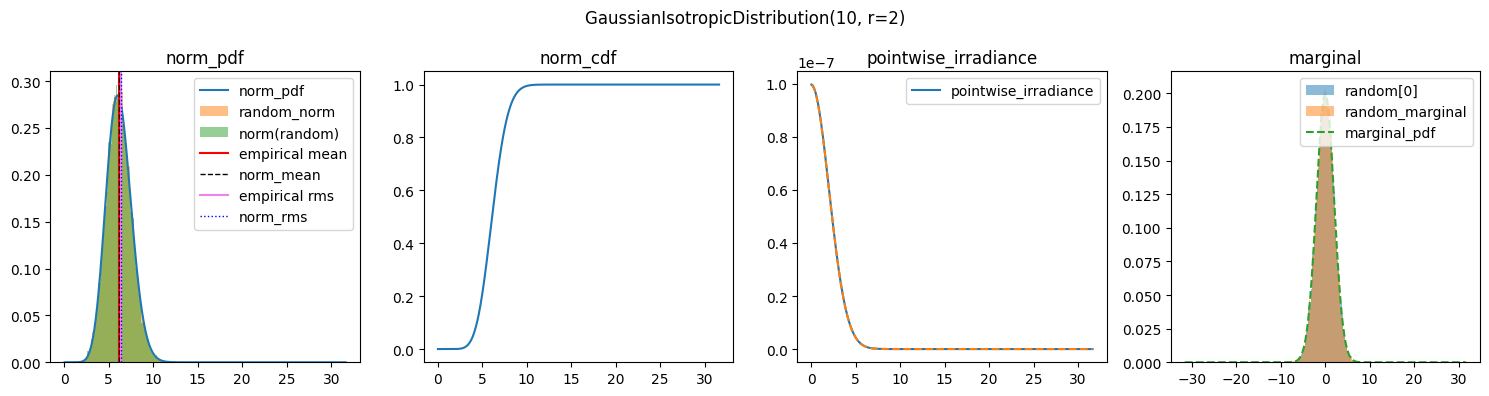

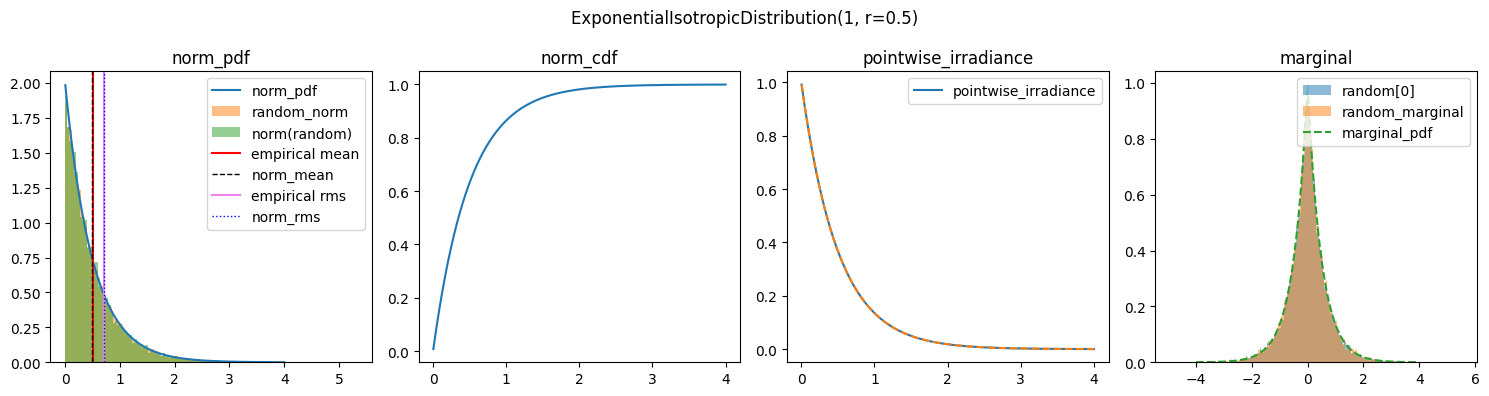

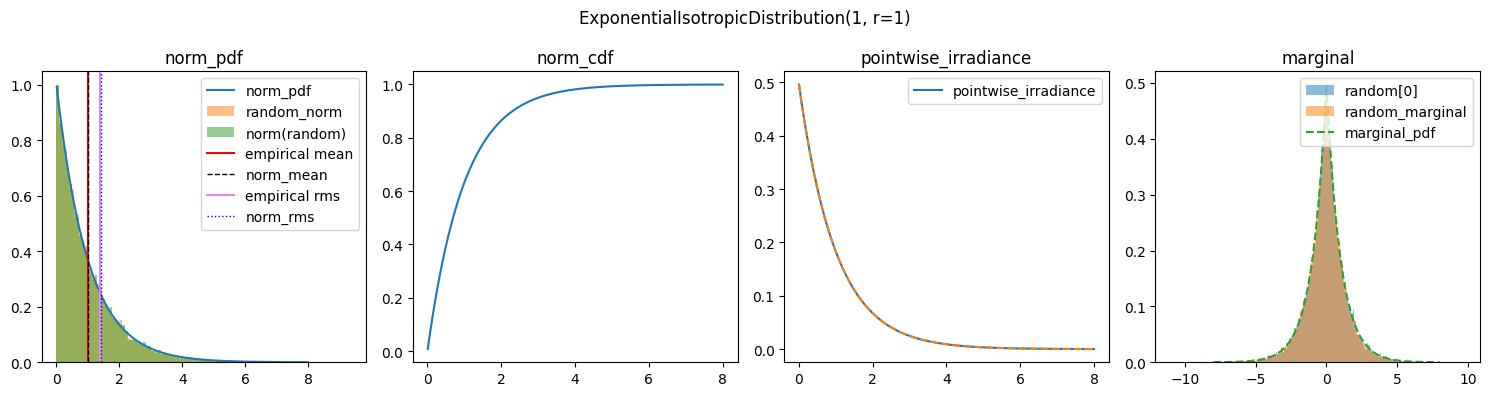

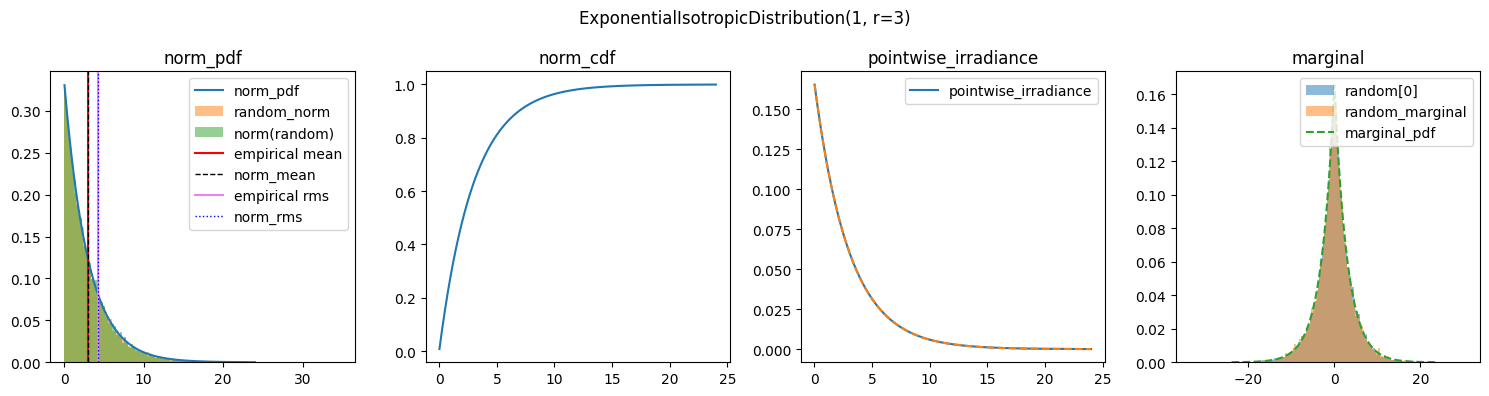

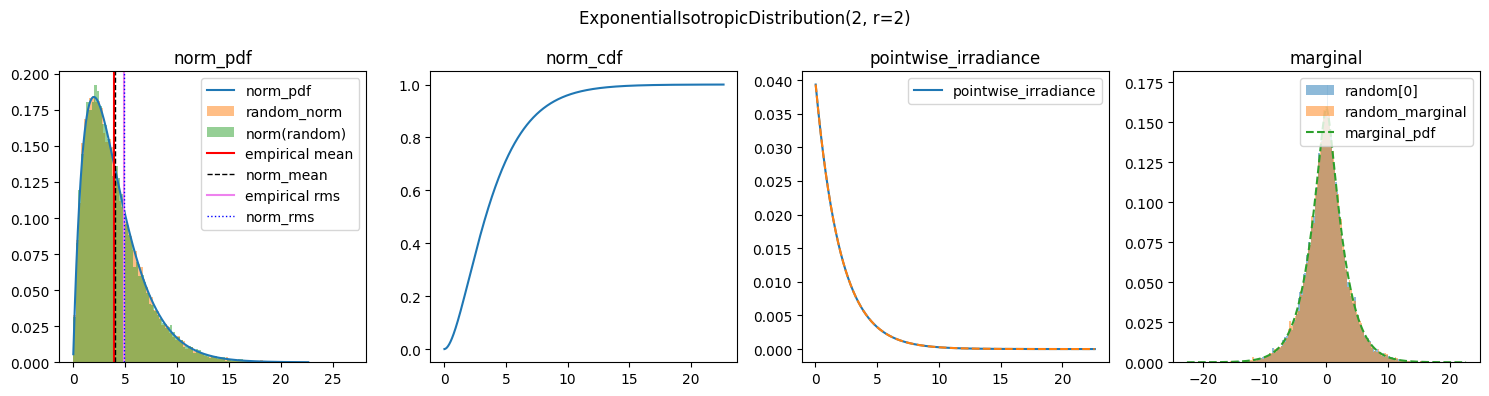

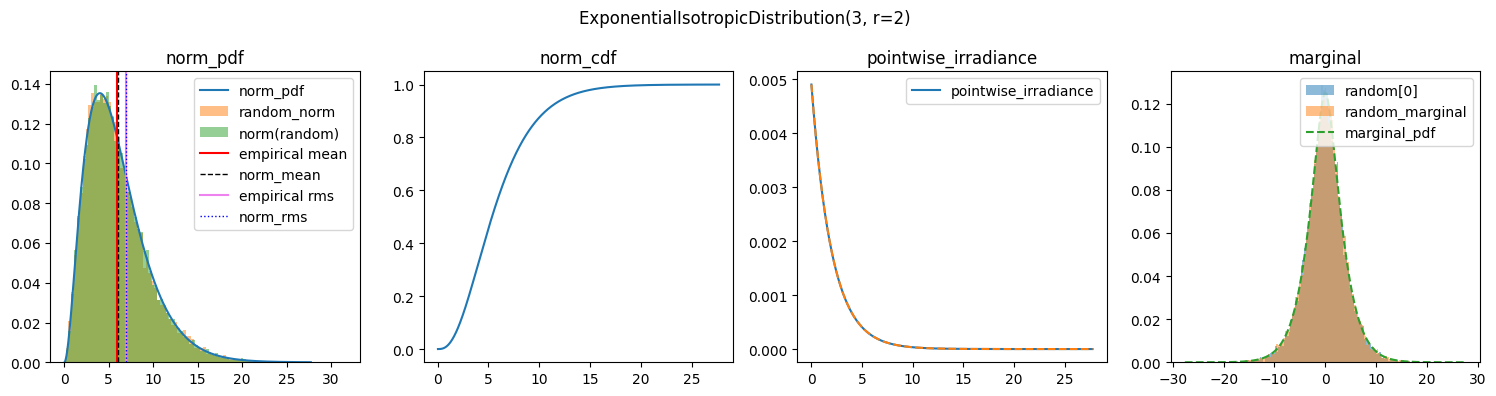

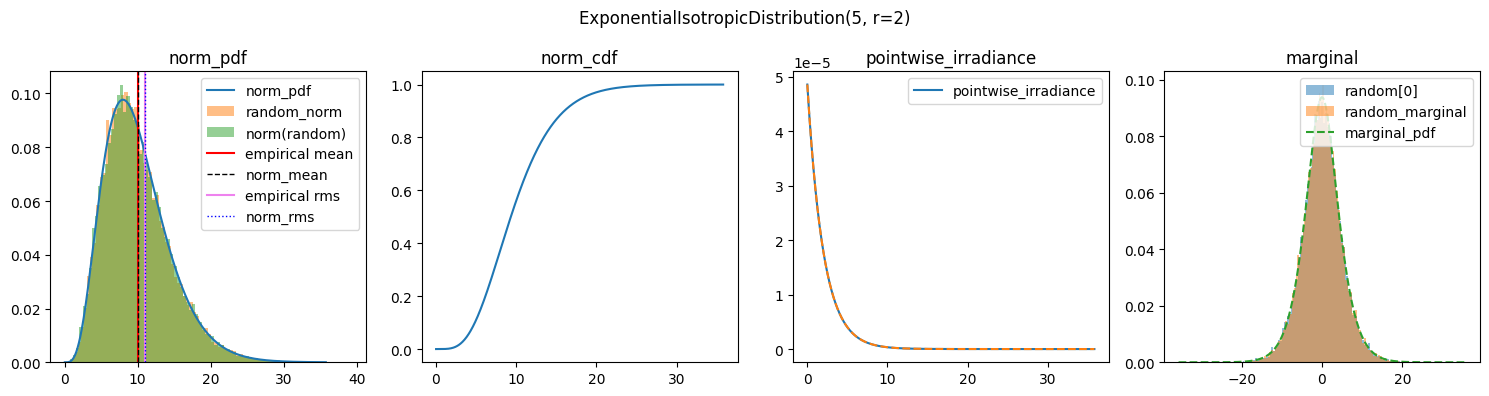

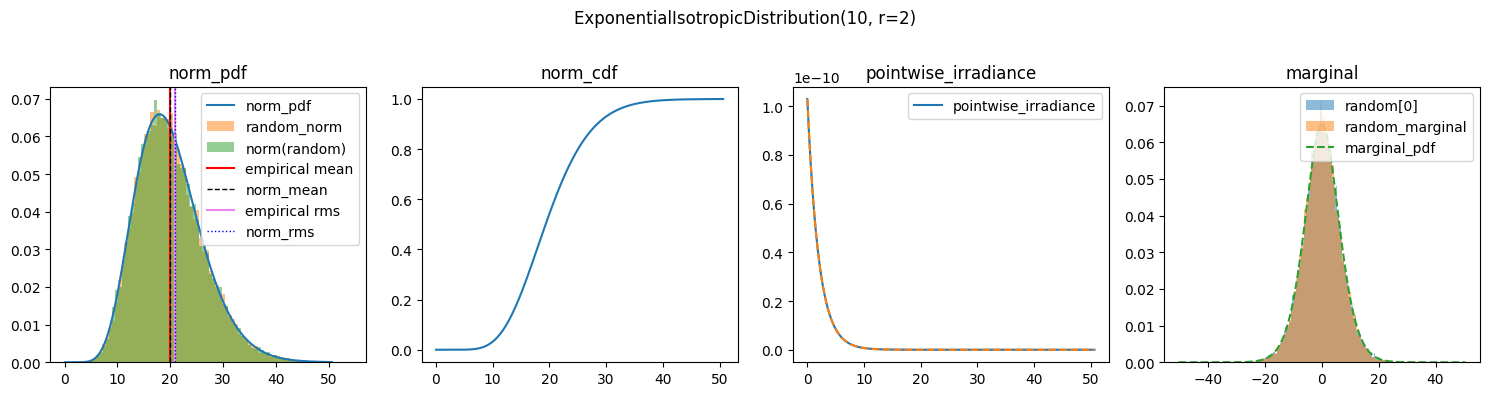

In [3]:

def basic_plots(dist: IstotropicDistribution, n=1000, n_samples=20000):
    rmax = dist._r_plot
    r = np.linspace(0, rmax, n)[1:]
    R = dist.random_norm(size=n_samples)
    R_method_2 = np.linalg.norm(dist.random(size=n_samples), axis=-1)
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes[0].plot(r, dist.norm_pdf(r), label='norm_pdf')
    axes[0].hist(R, bins="auto", density=True, alpha=0.5, label='random_norm')
    axes[0].hist(R_method_2, bins="auto", density=True, alpha=0.5, label='norm(random)')
    axes[0].axvline(R.mean(), color='r',  label='empirical mean')
    if isinstance(dist, ScipyIsotropicDistribution):
        axes[0].axvline(dist.norm_mean(), color='black', lw=1, linestyle='--', label='norm_mean')
    
    axes[0].axvline(np.sqrt(np.mean(R**2)), color='violet',  label='empirical rms')
    if isinstance(dist, ScipyIsotropicDistribution):
        axes[0].axvline(dist.norm_rms(), color='blue', lw=1, linestyle=':', label='norm_rms')
    axes[0].legend()
    axes[0].set_title('norm_pdf')
    axes[1].plot(r, dist.norm_cdf(r))
    axes[1].set_title('norm_cdf')
    axes[2].plot(r, dist.pointwise_irradiance(r), label='pointwise_irradiance')
    axes[2].set_title('pointwise_irradiance')
    try:
        y = dist._ref_irradiance(r)
        axes[2].plot(r, y, linestyle='--', label='_ref_irradiance') # type:ignore
    except NotImplementedError:
        pass
    axes[2].legend()
    axes[3].set_title('marginal')
    axes[3].hist(dist.random(size=n_samples)[:,0], bins="auto", density=True, alpha=0.5, label='random[0]')
    axes[3].hist(dist.random_marginal(size=n_samples), bins="auto", density=True, alpha=0.5, label='random_marginal')
    # axes[3].plot(r, dist._ref_marginal(r))
    try:
        x = np.linspace(-rmax, rmax, n)[1:]
        y = dist.marginal_pdf(x)
        axes[3].plot(x, y, linestyle='--', label='marginal_pdf') # type:ignore
    except NotImplementedError:
        pass
    axes[3].legend()
    plt.suptitle(repr(dist))
    plt.tight_layout()
    plt.show()


def point_weights(dist:IstotropicDistribution, X:np.ndarray, weights=None, filter_positive=False):
    'Weight each point x in X with its pointwise irradiance'
    # X, counts = np.unique(X, axis=0, return_counts=True)
    norms = np.linalg.norm(X, axis=-1)
    if weights is None:
        weights = np.ones_like(norms)
    weights = weights * dist.fuzzy_membership(norms)
    if filter_positive:
        X = X[weights>0]
        weights = weights[weights>0]
    return X, weights



class UniformIsotropicDistribution(ScipyIsotropicDistribution):
    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.beta(self.d, 1))
        self._rv_marginal = cast_rv_continuous(scipy.stats.beta((self.d+1)/2, (self.d+1)/2))
        self._r_plot = self.r*1.2
    
    def _ref_irradiance(self, r:float|np.ndarray):
        return np.where(r<self.r, 1, 0) / self.space.volume(self.r)
    
    def marginal_pdf(self, x:float|np.ndarray):
        # Reminder. This is equivalent:
        # return self.space.surface_marginal_pdf(x, d=self.d+2) / self.r
        x = np.clip(x/self.r, -1, 1)
        return self._rv_marginal.pdf((x+1)/2) / self.r / 2

    def random_marginal(self, size=None):
        # Alternative implementation
        return (self._rv_marginal.rvs(size=size) * 2 - 1)*self.r
    
    # Reminder: Random_radius alternatives:
    # Formula 1: np.random.random(size)**(1/self.d) * self.r
    # Formula 2: np.max(np.random.random((*shape, d)), axis=1) * self.r


class GaussianIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.chi(self.d))
        self._r_plot = self.r*self.d**0.5*5
    
    def random(self, size=None):
        shape = () if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        return X * self.r

    def _ref_irradiance(self, r:float|np.ndarray):
        rv = cast_rv_continuous(scipy.stats.halfnorm())
        c = 2**(self.d/2+1) / 5 * scipy.special.gamma(self.d/2)
        c *= self.space.surface(self.r)
        return rv.pdf(r/self.r)/self.r / c
    
    def marginal_pdf(self, x:float|np.ndarray):
        return scipy.stats.norm.pdf(x/self.r) / self.r


class ExponentialIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.gamma(self.d))
        self._r_plot = self.r*self.d**0.5*8

    def _ref_irradiance(self, r:float|np.ndarray):
        c = scipy.special.gamma(self.d) * self.space.surface(self.r)
        return 1 / self.r * np.exp(-r / self.r) / c
    
    def marginal_pdf(self, x:float|np.ndarray):
        # if self.d == 1: # Reminder: this code would be equivalent for d=1
        #     return np.exp(-np.abs(x)/self.r) / (2*self.r)
        d = self.d
        G = scipy.special.gamma
        c = 2**(d/2) / np.pi * G(1 + d/2) / G(1 + d)
        f = lambda x: scipy.special.kv(d/2, x) * x**(d/2)
        return c * f(np.abs(x)/self.r) / self.r



basic_plots(UniformIsotropicDistribution(1, r=1/2))
basic_plots(UniformIsotropicDistribution(1, r=1))
basic_plots(UniformIsotropicDistribution(1, r=3))

basic_plots(UniformIsotropicDistribution(2, r=2))
basic_plots(UniformIsotropicDistribution(3, r=2))
basic_plots(UniformIsotropicDistribution(5, r=2))
basic_plots(UniformIsotropicDistribution(10, r=2))

basic_plots(GaussianIsotropicDistribution(1, r=1/2))
basic_plots(GaussianIsotropicDistribution(1, r=1))
basic_plots(GaussianIsotropicDistribution(1, r=3))

basic_plots(GaussianIsotropicDistribution(2, r=2))
basic_plots(GaussianIsotropicDistribution(3, r=2))
basic_plots(GaussianIsotropicDistribution(5, r=2))
basic_plots(GaussianIsotropicDistribution(10, r=2))

basic_plots(ExponentialIsotropicDistribution(1, r=1/2))
basic_plots(ExponentialIsotropicDistribution(1, r=1))
basic_plots(ExponentialIsotropicDistribution(1, r=3))

basic_plots(ExponentialIsotropicDistribution(2, r=2))
basic_plots(ExponentialIsotropicDistribution(3, r=2))
basic_plots(ExponentialIsotropicDistribution(5, r=2))
basic_plots(ExponentialIsotropicDistribution(10, r=2))

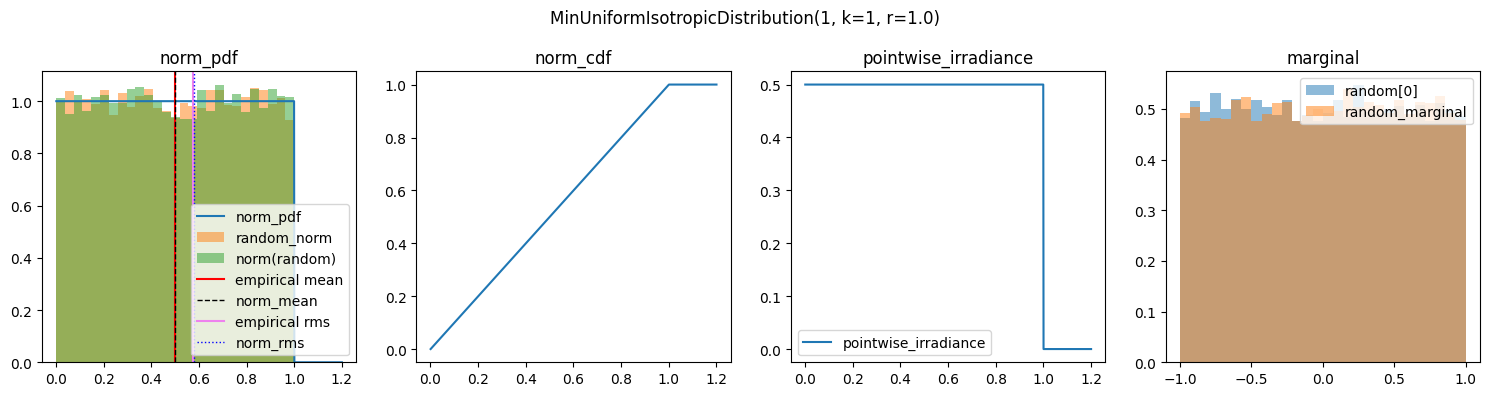

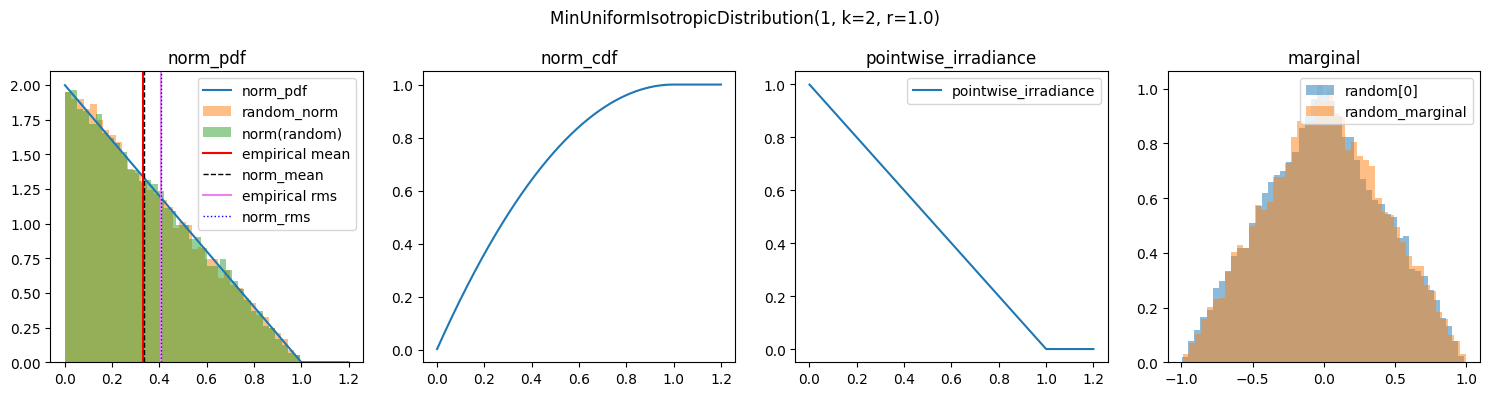

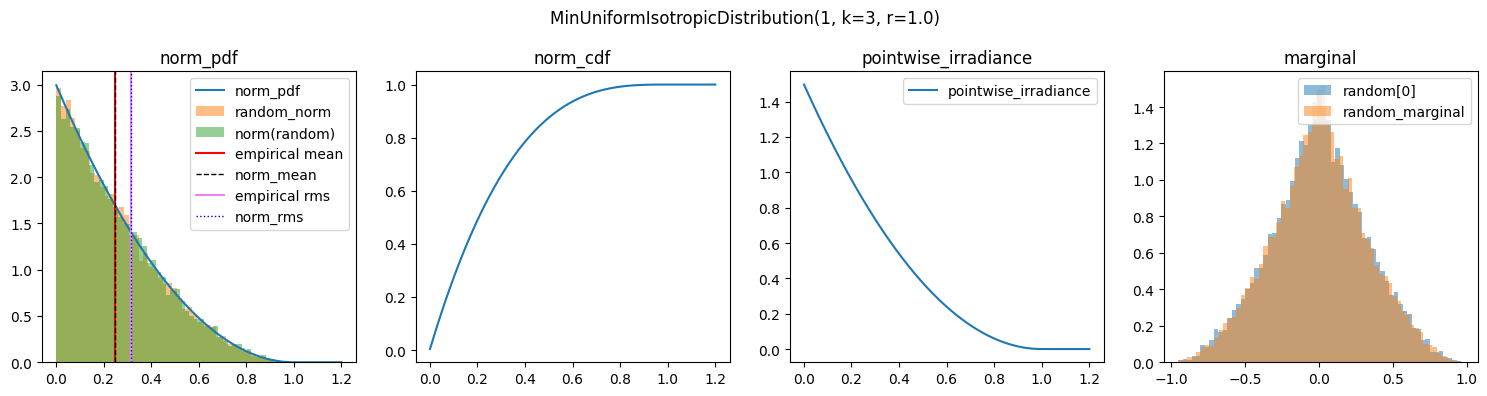

In [20]:

# marginal: 

class MinUniformIsotropicDistribution(ScipyIsotropicDistribution):
    '''
    The min-uniform distribution with shape parameter k is that of the minimum of k independent uniform distributions.
    '''

    def __init__(self, d:int, k:float, r:float=1.0):
        self.k = k
        super().__init__(d, r)

    def __repr__(self):
        return f"{self.__class__.__name__}({self.d}, k={self.k}, r={self.r})"

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.beta(self.d, self.k))
        self._r_plot = self.r*1.2
    
    # Marginal pdf: (Wolfram alpha times out).
    # c * x^(d-1) integral_x^1 (1/t**2 - 1)**((d-1)/2) * (1-x/t)**(k-1) dt
    # where c = C_((d-1)/2, (d-1)/2) * C_(d,k) * 2**(1-d)

basic_plots(MinUniformIsotropicDistribution(1, k=1))
basic_plots(MinUniformIsotropicDistribution(1, k=2))
basic_plots(MinUniformIsotropicDistribution(1, k=3))


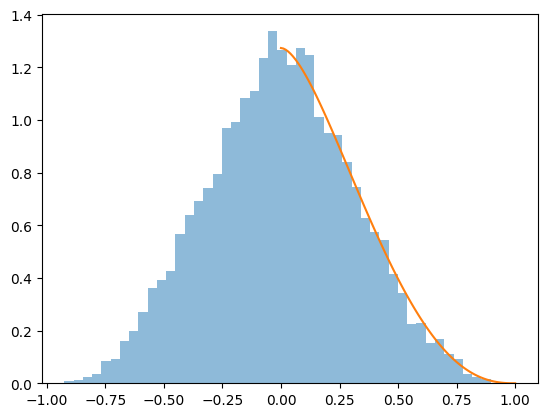

In [30]:
s = MinUniformIsotropicDistribution(2, k=3)

def compute_marginal_pdf(s: IstotropicDistribution, x:float) -> float:
    f = lambda r: s.pointwise_irradiance((r**2+x**2)**0.5) * s.space.d_surface(s.d-1, r)
    return scipy.integrate.quad(f, 0, np.inf)[0]

x = np.linspace(0, 1, 100)
y = np.array([compute_marginal_pdf(s, _x) for _x in x])
plt.hist(s.random_marginal(size=10000), bins="auto", density=True, alpha=0.5)
plt.plot(x, y)
plt.show()

In [28]:
# Find the formula for y using an automated library for fitting
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
df = pd.DataFrame({'x': x, 'y': y})
model = ols("y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5)", data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.310e+06
Date:                Sat, 17 Feb 2024   Prob (F-statistic):          1.59e-237
Time:                        14:05:17   Log-Likelihood:                 526.87
No. Observations:                 100   AIC:                            -1042.
Df Residuals:                      94   BIC:                            -1026.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2792      0.001   1805.817      0.0